<center> <h1>Workshop: Control Variables</h1> </center> 
<center> <h2>Rideshare demand estimation</h2> </center> 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

### 1. Setup




#### Download data/script files and launch Jupyter Notebook
1.	Create a new file folder on your computer
2.	Download the file “rideshare.csv” from Canvas to your folder
3.	Make sure the current notebook is in the same folder
4.  Load the data to a dataframe called rideshare


#### Data Description and Workshops Objective
The unit of observation (a row in the data) is an hour-long segment of ride-sharing activity in Los Angeles. The data contain information on how many rides were requested in a given time window, what price the ride-share app charged and how many rides were accepted by the customers.

We are interested in estimating the demand function, i.e., how many rides are accepted as a function of price. Empirical estimation of demand functions suffers from endogeneity, because the price is set by the company as a function of potential demand.

A useful feature of the app is that the customer only observes price AFTER requesting the ride. Hence, ride requests can be treated as a measure of potential demand that is unaffected by price. This means that in this type of data we can eliminate the endogeneity problem by using control variables.


In [2]:
rideshare = pd.read_csv('rideshare.csv')
rideshare.head()

,rides_request,price,rides_accepted
0,3050,3.0,1727
1,4532,3.5,2744
2,2547,2.5,1776
3,3644,3.0,2357
4,4527,3.5,2714


### 2. Data Exploration


#### 2.1 Price/rides relationship
**Q:** Fill the chunk below with code that regresses rides accepted on price. Interpret the results. Does this regression give you an unbiased estimate of the demand function?

In [3]:
rides_price_reg  = smf.ols(formula = 'rides_accepted ~ price', data = rideshare)
result = rides_price_reg.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:         rides_accepted   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                 2.942e+04
Date:                Thu, 21 Mar 2024   Prob (F-statistic):               0.00
Time:                        00:35:36   Log-Likelihood:                -70433.
No. Observations:               10000   AIC:                         1.409e+05
Df Residuals:                    9998   BIC:                         1.409e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -537.8947     15.312    -35.129      0.0

**A:** The regression suggests that, if price increased by 1 unit, the number of rides accepted increases by 907. The sign of the effect is counter-intuitive, as it suggests more demand at higher prices (so an upward sloping demand function). This is due to endogeneity in the regression (price is correlated with the regression error due to simultaneity). For ride-sharing apps in particular, it is likely that when there are a lot of ride requests, the app will charge a higher price (surge pricing) and hence higher demand leads to higher prices (rather than the other way around).

#### 2.1 Pricing scheme

To learn more about how the ride-share pricing is structured, we first plot rides requested on the X-axis and rides accepted on the Y-axis. We also plot rides requested on the X-axis and price on the Y-axis. 

**Q:**  Fill the chunk below with code that generates the plots. Based on these two graphs, how is pricing structured and can you visually see the impact of price on rides accepted?

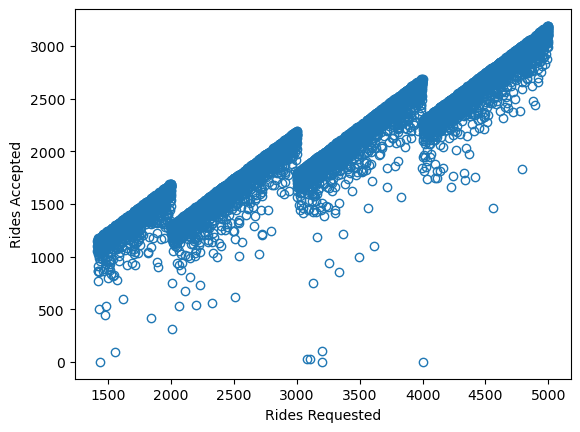

In [4]:
x = rideshare['rides_request']
y = rideshare['rides_accepted']
plt.plot(x, y, 'o',mfc = 'none') #scatter plot
plt.xlabel("Rides Requested")
plt.ylabel("Rides Accepted")
plt.show()

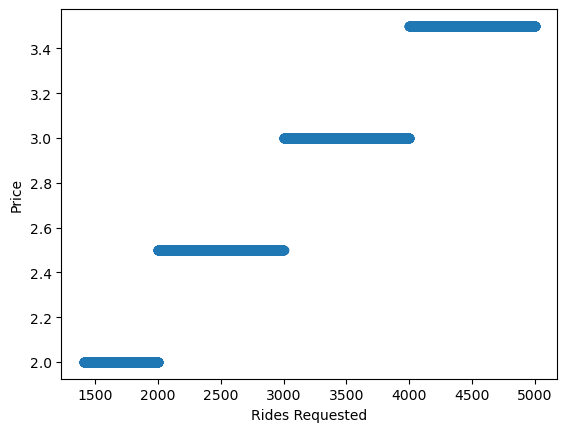

In [5]:
x = rideshare['rides_request']
y = rideshare['price']
plt.plot(x, y, 'o',mfc = 'none') #scatter plot
plt.xlabel("Rides Requested")
plt.ylabel("Price")
plt.show()

**A:** We can see the surge pricing structure: price is set for a certain number of ride requests, and as the number of requests passes a certain threshold, price increases to the next level. We can see from the graph of rides accepted on rides requested that demand drops sharply at each price jump.

### 3. Multivariate Regression


**Q:** Fill the chunk below with a regression of rides accepted on price using control variables. How does the price coefficient change relative to the earlier regression without the control? Does this regression give you an unbiased estimate of the demand function? Think about factors that determine rides accepted and how omitting them will lead to omitted variable bias.

In [6]:
rides_price_reg  = smf.ols(formula = 'rides_accepted ~ price + rides_request', data = rideshare)
result = rides_price_reg.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:         rides_accepted   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                 1.206e+05
Date:                Thu, 21 Mar 2024   Prob (F-statistic):               0.00
Time:                        00:38:30   Log-Likelihood:                -61170.
No. Observations:               10000   AIC:                         1.223e+05
Df Residuals:                    9997   BIC:                         1.224e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1446.8559     10.491    137.910

**A:** The price coefficient turns negative (-823) when we control for rides requested, which now is the expected sign for a demand curve. This means that we have omitted variable bias if we omit rides requested in the regression. Think about the naive regression in 2.1:
$$
Rides\_accepted = \beta_0 +\beta_1Price + e,
$$
here part of the error term would be
$$
e= \beta_2Rides\_request + u.
$$
Hence, we have OVB:
$$
E(\hat{\beta}_1) = \beta_1 + \frac{Cov(Price,e)}{Var(Price)} =\beta_1+\beta_2\frac{Cov(Price,Rides\_request)}{Var(Price)}.
$$
The sign of the bias is positive, and we are overestimating the effect of price on rides accepted if we omit rides requested, because $Cov(Price,Rides\_request)>0$ and $\beta_2>0$ (more rides requested is associated with more rides being accepted).

### 4. Local Regressions

We now see how the pricing structure with discrete price jumps could also be exploited to try and correct the endogeneity problem by running local regressions. This is useful if, for example, you only observe the variable rides requested in the neighborhood of the price jumps in the plots in section 2.2 (i.e, the price jumps at 2000, 3000 and 4000 rides requests)

#### 4.1 Focusing on first price jump

Let’s start by focusing on the first price jump that we know occurs at 2000 rides requests. We analyze changes in demand in the vicinity of this price change. We implement such an analysis by regressing rides accepted on price only for those observations where rides requested lie between 1950 and 2050 rides.


**Q:** Interpret the regression output. How does the coefficient on price compare with the earlier regression that used the entire dataset? Why do we obtain a negative price coefficient even without controlling for the rides requested?

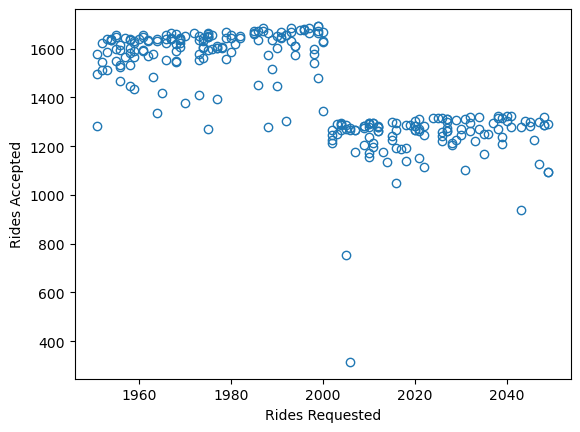

In [7]:
rideshare_jump_1 = rideshare[(rideshare['rides_request']>1950)  & (rideshare['rides_request']<2050)]
x = rideshare_jump_1['rides_request']
y = rideshare_jump_1['rides_accepted']
plt.plot(x, y, 'o',mfc = 'none') #scatter plot
plt.xlabel("Rides Requested")
plt.ylabel("Rides Accepted")
plt.show()

In [12]:
rideshare['jump_1'] = (rideshare['rides_request']>1950)  & (rideshare['rides_request']<2050)
rides_price_local_reg_01 = smf.ols(formula = 'rides_accepted ~ price', data = rideshare, subset = rideshare['jump_1'])
result = rides_price_local_reg_01.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:         rides_accepted   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     803.9
Date:                Thu, 21 Mar 2024   Prob (F-statistic):           3.14e-82
Time:                        00:46:06   Log-Likelihood:                -1611.7
No. Observations:                 267   AIC:                             3227.
Df Residuals:                     265   BIC:                             3235.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3013.9215     55.972     53.847      0.0

**A:** We are getting a negative coefficient for price. The plot of rides accepted on rides requested gives you some intuition for this: when rides requested are in the vicinity of the price jump that occurs at 2000 rides requested, the estimated price effect is mostly driven by the decrease in demand caused by the sharp price increase at the threshold, whereas the number of rides requested doesn’t vary much in the neighborhood of the price jump (i.e., we see large discrete jumps in the Y-axis but not in the X-axis).

#### 4.2 Other price jumps

So far we only looked at one price change, but we observe 3 jumps in our data.

**Q:** Run three more regressions based on 1) a window around 3000; 2) a window around 4000 and 3) the pooled regression that uses observations from all three windows. Think carefully about how to set up this pooled regression. In particular, ask yourself whether combining data from all 3 windows requires you to include additional control variables.


In [13]:
rideshare['jump_2'] = (rideshare['rides_request']>2950)  & (rideshare['rides_request']<3050)
rideshare['jump_3'] = (rideshare['rides_request']>3950)  & (rideshare['rides_request']<4050)

In [14]:
rides_price_local_reg_02 = smf.ols(formula = 'rides_accepted ~ price', data = rideshare, subset = rideshare['jump_2'])
result = rides_price_local_reg_02.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:         rides_accepted   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     1750.
Date:                Thu, 21 Mar 2024   Prob (F-statistic):          1.12e-123
Time:                        00:46:56   Log-Likelihood:                -1632.0
No. Observations:                 287   AIC:                             3268.
Df Residuals:                     285   BIC:                             3275.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3871.9212     46.912     82.536      0.0

In [15]:
rides_price_local_reg_03 = smf.ols(formula = 'rides_accepted ~ price', data = rideshare, subset = rideshare['jump_3'])
result = rides_price_local_reg_03.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:         rides_accepted   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     372.3
Date:                Thu, 21 Mar 2024   Prob (F-statistic):           1.05e-53
Time:                        00:46:58   Log-Likelihood:                -1878.2
No. Observations:                 288   AIC:                             3760.
Df Residuals:                     286   BIC:                             3768.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4852.5284    126.911     38.236      0.0

In [16]:
# pooled regression based on all three price jumps
rideshare['jump_all'] = rideshare['jump_1'] | rideshare['jump_2'] | rideshare['jump_3']

rides_price_local_reg_all = smf.ols(formula = 'rides_accepted ~ price + jump_2 + jump_3', data = rideshare, subset = rideshare['jump_all'])
result = rides_price_local_reg_all.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:         rides_accepted   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     3700.
Date:                Thu, 21 Mar 2024   Prob (F-statistic):               0.00
Time:                        00:47:38   Log-Likelihood:                -5221.6
No. Observations:                 842   AIC:                         1.045e+04
Df Residuals:                     838   BIC:                         1.047e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       3043.8903     37.479     81.

In [17]:
# pooled regression without "window control" (NOTE: this specification is wrong!)
rides_price_local_reg_all_wrong = smf.ols(formula = 'rides_accepted ~ price', data = rideshare, subset = rideshare['jump_all'])
result = rides_price_local_reg_all_wrong.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:         rides_accepted   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     360.4
Date:                Thu, 21 Mar 2024   Prob (F-statistic):           3.87e-67
Time:                        00:48:33   Log-Likelihood:                -6189.6
No. Observations:                 842   AIC:                         1.238e+04
Df Residuals:                     840   BIC:                         1.239e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    534.5628     74.849      7.142      0.0

**A:** There is a positive relationship between realized and potential demand to the left and right of each window. The more we narrow the window, the closer we get to the price coefficient from the regression with the potential-demand control.

**BONUS Q:** Why is the price coefficient in the pooled local regression smaller (in absolute value) than the price coefficient in the multivariate regression that uses all observations and controls for rides requested?

**A:** The use of local regression mitigates the bias due to the omitted variable rides requested, but does not completely eliminate it. Hence there is still a slight upward bias in the price coefficient.